In [1]:
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from GridWorld import Task
from Agents import Task, TaskSetAgent, IndependentClusterAgent
from utils import randomize_order

In [2]:
# define all of the task parameters here
gridworld_size = (6, 6)

map_0 = {0: u'left', 1: u'up', 2: u'down', 3: u'right'}
map_1 = {4: u'up', 5: u'left', 6: u'right', 7: u'down'}

goal_0 = (0, 0)
goal_1 = (0, 5)
goal_2 = (5, 0)
goal_3 = (5, 5)

start_locations = [(2, 2), (2, 3), (3, 2), (3, 3)]

context_goals = [goal_0, goal_1, goal_2, goal_3, goal_0, goal_3]
context_maps = [map_0, map_0, map_0, map_0, map_1, map_1]
context_balance = [2, 2, 6, 6, 4, 4]

hazard_rates = [0.5, 0.67, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

list_goal_priors = [(0, 0), (0, 5), (5, 0), (5, 5)]

In [3]:
def make_task():
    list_context = list()
    list_start_locations = list()
    list_goals = list()
    list_maps = list()
    for ctx, n_reps in enumerate(context_balance):
        list_context += [ctx] * n_reps
        list_start_locations += [start_locations[np.random.randint(4)] for _ in range(n_reps)]
        list_goals += [context_goals[ctx] for _ in range(n_reps)]
        list_maps += [context_maps[ctx] for _ in range(n_reps)]

    order = randomize_order(context_balance, hazard_rates)

    list_start_locations = [list_start_locations[idx] for idx in order]
    list_context = [list_context[idx] for idx in order]
    list_goals = [list_goals[idx] for idx in order]
    list_maps = [list_maps[idx] for idx in order]
    list_walls = [[]] * len(order)

    args = [list_start_locations, list_goals, list_context, list_maps]
    kwargs = dict(list_walls=list_walls, grid_world_size=(6, 6))
    return Task(*args, **kwargs)


def simulate(agent_class, simulation_number, agent_kwargs=None):
    task = make_task()
    if agent_kwargs is not None:
        agent = agent_class(task, **agent_kwargs)
    else:
        agent = agent_class(task)
    agent.set_reward_prior(list_goal_priors)

    results = agent.generate()
    results['Simulation Number'] = [simulation_number] * len(results)
    results['Cumulative Steps Taken'] = results['n actions taken'].cumsum()

    return results

In [4]:
n_sim = 10

resultsTS = pd.concat([simulate(TaskSetAgent, ii) for ii in range(n_sim)])
resultsIC = pd.concat([simulate(IndependentClusterAgent, ii) for ii in range(n_sim)])
resultsTS['Model'] = ['Task Set'] * len(resultsTS)
resultsIC['Model'] = ['Independent Clustering'] * len(resultsIC)
results = pd.concat([resultsTS, resultsIC])

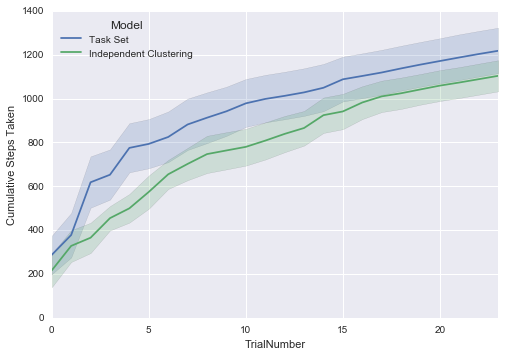

In [5]:
kwargs = dict(
    time='TrialNumber',
    value='Cumulative Steps Taken',
    data=results[results['In goal']], 
    unit='Simulation Number',
    condition='Model'
)
sns.tsplot(**kwargs)